# Sampling

Content credits on the [Acknowledgments Page](https://ds100.org/sp23/acks/).

Updated by Dominic Liu, Fernando Pérez.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid', font_scale = 1.5,
              rc={'figure.figsize':(7,5)})

rng = np.random.default_rng()

## Barbie v. Oppenheimer

We are trying to collect a sample from Berkeley residents to predict the which one of Barbie and Oppenheimer would perform better on their opening day, July 21st.

First, let's grab a dataset that has every single residents in Berkeley (this is a fake dataset) and which movie they **actually** watched on July 21st.

For the purposes of this demo, assume:
* `is_male` indicates if a resident identifies as male.
* There are only two movies they can watch on July 21st: Barbie and Oppenheimer.
* Every resident watches a movie (either Barbie or Oppenheimer) on July 21st.


In [2]:
movie = pd.read_csv("movie.csv")

# create a 1/0 int that indicates Barbie vote
movie['barbie'] = (movie['movie'] == 'Barbie').astype(int)
movie

,age,is_male,movie,barbie
0,35,False,Barbie,1
1,42,True,Oppenheimer,0
2,55,False,Barbie,1
3,77,True,Oppenheimer,0
4,31,False,Barbie,1
...,...,...,...,...
1299995,62,True,Barbie,1
1299996,78,True,Oppenheimer,0
1299997,68,False,Oppenheimer,0
1299998,82,True,Oppenheimer,0


What fraction of Berkeley residents chose Barbie?

In [3]:
actual_barbie = np.mean(movie["barbie"])
actual_barbie

0.5302792307692308

This is the **actual outcome** of the competition. Based on this result, Barbie would win. How did our sample of retirees do?

## Convenience sample: retirees

In [4]:
convenience_sample = movie[movie['age'] >= 65]
np.mean(convenience_sample["barbie"])

0.3744755089093924

Based on this result, we would have predicted that Oppenheimer would win! What happened?

1. Is the sample too small / noisy?

In [5]:
len(convenience_sample)

359396

In [6]:
len(convenience_sample)/len(movie)

0.27645846153846154

Seems really large, so the error is definitely not solely chance error. There is some bias afoot.

### Check for bias

Let us aggregate all choices by age and visualize the fraction of Barbie views, split by gender.

In [7]:
votes_by_barbie = movie.groupby(["age","is_male"]).agg("mean", numeric_only=True).reset_index()
votes_by_barbie

,age,is_male,barbie
0,18,False,0.819594
1,18,True,0.667001
2,19,False,0.812214
3,19,True,0.661252
4,20,False,0.805281
...,...,...,...
125,80,True,0.259731
126,81,False,0.394946
127,81,True,0.256759
128,82,False,0.398970


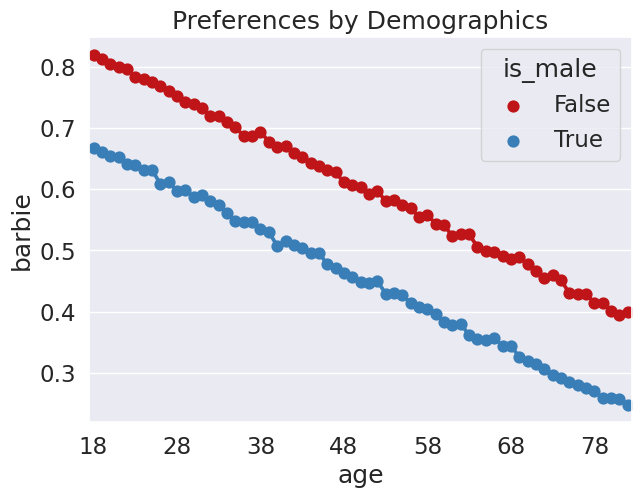

In [8]:
# A common matplotlib/seaborn pattern: create the figure and axes object, pass ax
# to seaborn for drawing into, and later fine-tune the figure via ax.
fig, ax = plt.subplots();

red_blue = ["#bf1518", "#397eb7"]
with sns.color_palette(red_blue):
    sns.pointplot(data=votes_by_barbie, x = "age", y = "barbie", hue = "is_male", ax=ax)

new_ticks = [i.get_text() for i in ax.get_xticklabels()]
ax.set_xticks(range(0, len(new_ticks), 10), new_ticks[::10])
ax.set_title("Preferences by Demographics");

* We see that retirees (in Berkeley) tend to watch Oppenheimer.
* We also see that residents who identify as non-male tend to prefer Barbie.

## Simple Random Sample

What if we instead took a simple random sample (SRS) to collect our sample?

Suppose we took an SRS of the same size as our retiree sample:

In [9]:
## By default, replace = False
n = len(convenience_sample)
random_sample = movie.sample(n, replace = False)

np.mean(random_sample["barbie"])

0.5302396242584781

This is very close to the actual vote!

In [10]:
actual_barbie

0.5302792307692308

It turns out that we can get similar results with a **much smaller sample size**, say, 800:

In [11]:
n = 800
random_sample = movie.sample(n, replace = False)

# Compute the sample average and the resulting relative error
sample_barbie = np.mean(random_sample["barbie"])
err = abs(sample_barbie-actual_barbie)/actual_barbie

# We can print output with Markdown formatting too...
from IPython.display import Markdown
Markdown(f"**Actual** = {actual_barbie:.4f}, **Sample** = {sample_barbie:.4f}, "
         f"**Err** = {100*err:.2f}%.")

**Actual** = 0.5303, **Sample** = 0.5112, **Err** = 3.59%.

We'll learn how to choose this number when we (re)learn the Central Limit Theorem later in the semester.

### Quantifying chance error

In our SRS of size 800, what would be our chance error?

Let's simulate 1000 versions of taking the 800-sized SRS from before:

In [12]:
nrep = 1000   # number of simulations
n = 800       # size of our sample
poll_result = []
for i in range(0, nrep):
    random_sample = movie.sample(n, replace = False)
    poll_result.append(np.mean(random_sample["barbie"]))

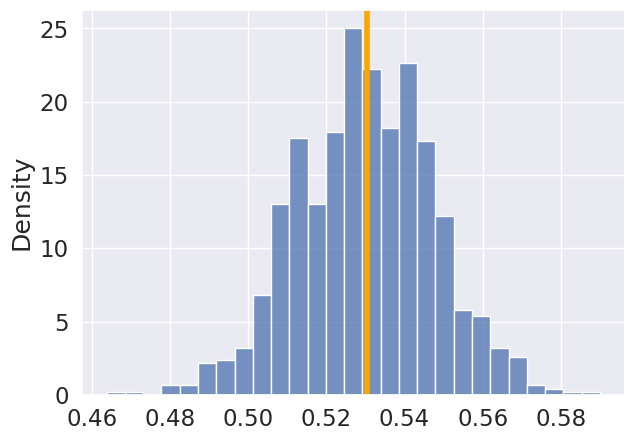

In [13]:
fig, ax = plt.subplots()
sns.histplot(poll_result, stat='density', ax=ax)
ax.axvline(actual_barbie, color="orange", lw=4);

What fraction of these simulated samples would have predicted Barbie?

In [14]:
poll_result = pd.Series(poll_result)
np.sum(poll_result > 0.5)/1000

0.956

You can see the curve looks roughly Gaussian/normal. Using KDE:

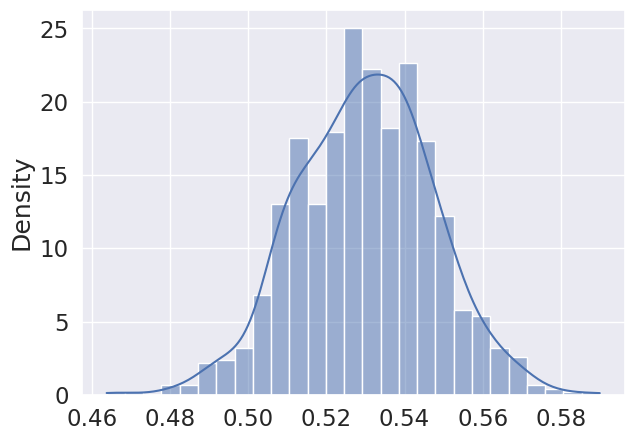

In [15]:
sns.histplot(poll_result, stat='density', kde=True);

---

## Simulating from a Multinomial Distribution

Sometimes instead of having individual reports in the population, we have **aggregate** statistics. For example, we could have only learned that 53\% of election voters voted Democrat. Even so, we can still simulate probability samples if we assume the population is large.

Specifically, we can use **multinomial** probabilities to simulate random samples **with replacement**.

### Marbles

Suppose we have a very large bag of marbles with the following statistics:
* 60\% blue
* 30\% green
* 10\% red

We then draw 100 marbles from this bag at random with replacement.

In [16]:
np.random.multinomial(100, [0.60, 0.30, 0.10])

array([59, 32,  9])

We can repeat this simulation multiple times, say 20:

In [17]:
np.random.multinomial(100, [0.60, 0.30, 0.10], size=20)

array([[66, 25,  9],
       [62, 29,  9],
       [52, 34, 14],
       [69, 19, 12],
       [60, 30, 10],
       [60, 26, 14],
       [63, 27, 10],
       [67, 23, 10],
       [56, 33, 11],
       [55, 38,  7],
       [57, 33, 10],
       [55, 36,  9],
       [54, 38,  8],
       [64, 26, 10],
       [57, 29, 14],
       [61, 28, 11],
       [68, 24,  8],
       [52, 32, 16],
       [51, 37, 12],
       [57, 35,  8]])